# CopyCat: Example Usage on Argsme

In [1]:
# Download the argsme anserini index
import os.path
INDEX='copycat-on-argsme-data/index'
RUN_DIR='copycat-on-argsme-data/touche-runs-task1-2020'

!mkdir -p copycat-on-argsme-data
if not os.path.isfile('copycat-on-argsme-data/argsme-index.tar.gz') or not os.path.isdir(INDEX):
    !wget -O copycat-on-argsme-data/argsme-index.tar.gz 'https://files.webis.de/data-in-progress/touche20/argsme-anserini-premise-conclusion-porter-stemmer.tar.gz'
    !tar -xvzf copycat-on-argsme-data/argsme-index.tar.gz -C copycat-on-argsme-data
    
    !wget -O copycat-on-argsme-data/touche-runs-task1-2020.zip  https://webis.de/events/touche-21/runs-task-1-2020.zip
    !unzip copycat-on-argsme-data/touche-runs-task1-2020.zip -d $RUN_DIR
else:
    print('Argsme index is already downloaded.')


Argsme index is already downloaded.


In [2]:
!cp $RUN_DIR/runs-task-1/touche-2020-first-task-dataset-v2/'Swordsman Baseline'/Run/run.txt delete-me-baseline-run-argsme

!../bash/copy-cat.sh \
    --output copycat-on-argsme-data/delete-me-run-baseline-top100.jsonl \
    --input delete-me-baseline-run-argsme \
    --similarities "url s3 cosine(3+5-grams) cosine(8-grams) cosine(1-grams) simhash(1-grams) simhash(3+5-grams) md5 text-profile" \
    --s3Threshold 0.6 \
    --threads 5 \
    --ranks 100 \
    --documents AnseriniIndex \
    --anseriniIndex $INDEX

The specified output 'copycat-on-argsme-data/delete-me-run-baseline-top100.jsonl' exists.
Skip...


In [3]:
!../bash/copy-cat.sh \
    --output copycat-on-argsme-data/delete-me-run-baseline-top1000.jsonl \
    --input delete-me-baseline-run-argsme \
    --similarities "url s3 cosine(3+5-grams) cosine(8-grams) cosine(1-grams) simhash(1-grams) simhash(3+5-grams) md5 text-profile" \
    --s3Threshold 0.6 \
    --threads 5 \
    --ranks 1000 \
    --documents AnseriniIndex \
    --anseriniIndex $INDEX

The specified output 'copycat-on-argsme-data/delete-me-run-baseline-top1000.jsonl' exists.
Skip...


In [4]:
import json
import pandas as pd

def eval_with_threshold(threshold, run_file_name):
    rows = []
    with open(run_file_name) as jsonl_file:
        for jsonl in jsonl_file:
            dedup_data = json.loads(jsonl)
            docs_to_remove = []
            
            for sim in dedup_data['similarities']:
                if sim['similarities']['s3'] >=  threshold:
                    docs_to_remove += [sim['secondId']]

                
            rows += [{
                    'topic': dedup_data['topic'],
                    'duplicates': len(set(docs_to_remove)),
                    'docs': dedup_data['docs'],
                }]

    return rows

def eval_runs_with_threshold(threshold, run_files):
    rows = []
    for r in run_files:
        rows += eval_with_threshold(threshold, r)
    
    return pd.DataFrame(rows)

In [5]:
DEDUP_TARGET_DIR='copycat-on-argsme-data/'
ALL_DIRS=!ls $DEDUP_TARGET_DIR
ALL_DIRS = [DEDUP_TARGET_DIR + i for i in ALL_DIRS if '.jsonl' in i]

df = eval_runs_with_threshold(0.82, ALL_DIRS)
df['redundancy'] = df['duplicates']/df['docs']

In [6]:
df[['docs', 'redundancy']].groupby('docs').mean()

,redundancy
docs,
100,0.0256
1000,0.0220


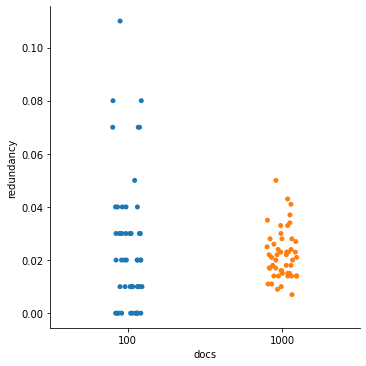

In [8]:
import seaborn as sns
sns.catplot(data=df, x='docs', y='redundancy', hue='docs')